# Imports

In [1]:
from pathlib import Path
import json
import collections

import pandas as pd
import matplotlib.pyplot as plt


# Paths

Raw and processed data will be stored in the data directory. Paths to various forms of the data are listed below

In [2]:
RAW_PATH = Path("../data/raw/conference_data_25.json")  # adjust ../ if needed

# Initial Inspections

The scraper extracted a number of metadata, but further refining is required. For this project we require information about the papers being reviewed, and any decisions amde about them. This initial work is made to ensure each entry contains the necessary information.

In [3]:
with RAW_PATH.open("r", encoding="utf-8") as f:
    records = json.load(f)

len(records), records[0]

(11672,
 {'venue': 'ICLR.cc',
  'year': '2025',
  'paper_id': '5sRnsubyAK',
  'title': 'Neuroacoustic Patterns: Constant Q Cepstral Coefficients for the Classification of Neurodegenerative Disorders',
  'abstract': 'Early identification of neurodegenerative diseases is crucial for effective diagnosis in neurological disorders. However, the quasi-periodic nature of vocal tract sampling often results in inadequate spectral resolution in traditional spectral features, such as Mel Frequency Cepstral Coefficients (MFCC), thereby limiting their classification effectiveness. In this study, we propose the use of Constant Q Cepstral Coefficients (CQCC), which leverage geometrically spaced frequency bins to provide superior spectrotemporal resolution, particularly for capturing the fundamental frequency and its harmonics in speech signals associated with neurodegenerative disorders. Our results demonstrate that CQCC, when integrated with Random Forest and Support Vector Machine classifiers, sign

In [4]:
num_with_decision = sum(1 for r in records if r.get("decision"))
num_with_title = sum(1 for r in records if r.get("title"))
num_with_abstract = sum(1 for r in records if r.get("abstract"))

num_with_decision, num_with_title, num_with_abstract

(8727, 11672, 11672)

As we can see above, over a thousand entries lack decisions. It may be worth examining what these entries look like to understand why they might be missing

In [5]:
missing_decision = [r for r in records if not r.get("decision")]
len(missing_decision)

2945

In [7]:
missing_decision[0]

{'venue': 'ICLR.cc',
 'year': '2025',
 'paper_id': '5sRnsubyAK',
 'title': 'Neuroacoustic Patterns: Constant Q Cepstral Coefficients for the Classification of Neurodegenerative Disorders',
 'abstract': 'Early identification of neurodegenerative diseases is crucial for effective diagnosis in neurological disorders. However, the quasi-periodic nature of vocal tract sampling often results in inadequate spectral resolution in traditional spectral features, such as Mel Frequency Cepstral Coefficients (MFCC), thereby limiting their classification effectiveness. In this study, we propose the use of Constant Q Cepstral Coefficients (CQCC), which leverage geometrically spaced frequency bins to provide superior spectrotemporal resolution, particularly for capturing the fundamental frequency and its harmonics in speech signals associated with neurodegenerative disorders. Our results demonstrate that CQCC, when integrated with Random Forest and Support Vector Machine classifiers, significantly out

## My Verdict

It looks like the majority of papers with a null value for decision were unanimously rejected. Thus I think it's fair to also assign these entries as rejected.

In [8]:
decision_counts = collections.Counter(
    (r.get("decision") or "MISSING") for r in records
)
decision_counts

Counter({'Reject': 5019, 'Accept': 3708, 'MISSING': 2945})

Below we will assign each entry a value of 0 or 1 depending on its decision. As decided above, entries missing a decision value will be assigned 0 (rejected). This will be the clean dataset moving forward.

In [9]:
def decision_to_label(decision):
    """
    Map decisions to labels:
    - Accept => 1
    - Everything else (None, missing, rejects) => 0
    """
    if not decision:
        return 0
    d = str(decision).lower()
    if "accept" in d:
        return 1
    return 0


clean_examples = []

for r in records:
    title = (r.get("title") or "").strip()
    abstract = (r.get("abstract") or "").strip()

    # Skip incomplete metadata
    if not title or not abstract:
        continue

    decision = r.get("decision")
    label = decision_to_label(decision)

    venue = r.get("venue")
    year = r.get("year")
    paper_id = r.get("paper_id")

    # Extract reviews
    raw_reviews = r.get("reviews", []) or []

    processed_reviews = []
    for rev in raw_reviews:
        processed_reviews.append({
            "summary": rev.get("summary"),
            "strengths": rev.get("strengths"),
            "weaknesses": rev.get("weaknesses"),
            "questions": rev.get("questions"),
            "rating": rev.get("rating"),
            "confidence": rev.get("confidence"),
        })

    clean_examples.append({
        "venue": venue,
        "year": year,
        "paper_id": paper_id,
        "title": title,
        "abstract": abstract,
        "decision": decision,  # may be None
        "label": label,        # 1 = accept, 0 = reject
        "reviews": processed_reviews,
    })

len(clean_examples)

11672

## Initial inspection of cleaned data

In [10]:
df = pd.DataFrame(clean_examples)
df.head()


,venue,year,paper_id,title,abstract,decision,label,reviews
0,ICLR.cc,2025,5sRnsubyAK,Neuroacoustic Patterns: Constant Q Cepstral Co...,Early identification of neurodegenerative dise...,None,0,[{'summary': 'The paper introduces a new featu...
1,ICLR.cc,2025,J1SGf2lyr6,A Feature-Aware Federated Learning Framework f...,The expansion of 5G networks has led to remark...,None,0,[{'summary': 'This paper presents a Feature-Aw...
2,ICLR.cc,2025,49ti6LOUw5,UnoLoRA: Single Low-Rank Adaptation for Effici...,Recent advances in Parameter-Efficient Fine-Tu...,None,0,"[{'summary': 'The paper presents UnoLoRA, an a..."
3,ICLR.cc,2025,zkNCWtw2fd,Synergistic Approach for Simultaneous Optimiza...,Information retrieval across different languag...,Reject,0,[{'summary': 'This paper introduces a hybrid b...
4,ICLR.cc,2025,viQ1bLqKY0,EXecution-Eval: Can language models execute re...,"As Large Language Models (LLMs) advance, tradi...",Reject,0,"[{'summary': 'The paper introduces EXE, a new ..."


We can calculate the distribution of decisions below

In [11]:
df["label"].value_counts(normalize=True)

label
0    0.682317
1    0.317683
Name: proportion, dtype: float64

In [12]:
df["abstract_len"] = df["abstract"].str.len()
df["abstract_len"].describe()

count    11672.000000
mean      1373.695168
std        311.889149
min          1.000000
25%       1164.000000
50%       1356.000000
75%       1569.000000
max       3318.000000
Name: abstract_len, dtype: float64

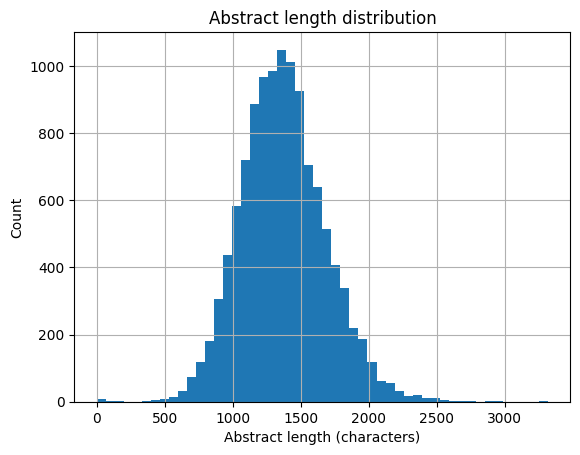

In [13]:
df["abstract_len"].hist(bins=50)
plt.xlabel("Abstract length (characters)")
plt.ylabel("Count")
plt.title("Abstract length distribution");

We have a few entries with abstracts that barely exist. It might be worth dropping those. But I think we can keep them.

## Deduplicate (if any exist)

In [14]:
df.duplicated(subset=["title", "abstract"]).sum()

0

# Export cleaned data

In [15]:
CLEAN_PATH = Path("../data/processed/iclr2025.json")

In [16]:
CLEAN_PATH.parent.mkdir(parents=True, exist_ok=True)

with CLEAN_PATH.open("w", encoding="utf-8") as f:
    for _, row in df.iterrows():
        obj = {
            "venue": row["venue"],
            "year": row["year"],
            "paper_id": row["paper_id"],
            "title": row["title"],
            "abstract": row["abstract"],
            "decision": row["decision"],
            "label": int(row["label"]),
            "reviews": row["reviews"],
        }
        f.write(json.dumps(obj, ensure_ascii=False) + "\n")

CLEAN_PATH, len(df)

(PosixPath('../data/processed/iclr2025.json'), 11672)

## Note

The above returns a JSONL file since the dataset is fairly large